In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
!pip install sqlalchemy

You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
for row in session.query(Measurement, Measurement.prcp).limit(5).all():
    print(row)

(<sqlalchemy.ext.automap.measurement object at 0x0000023CCC00FD60>, 0.08)
(<sqlalchemy.ext.automap.measurement object at 0x0000023CCC00FCA0>, 0.0)
(<sqlalchemy.ext.automap.measurement object at 0x0000023CCC00FC70>, 0.0)
(<sqlalchemy.ext.automap.measurement object at 0x0000023CCC00FC40>, 0.0)
(<sqlalchemy.ext.automap.measurement object at 0x0000023CCC00FC10>, None)


# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = recent_date[0]

TypeError: 'datetime.datetime' object is not subscriptable

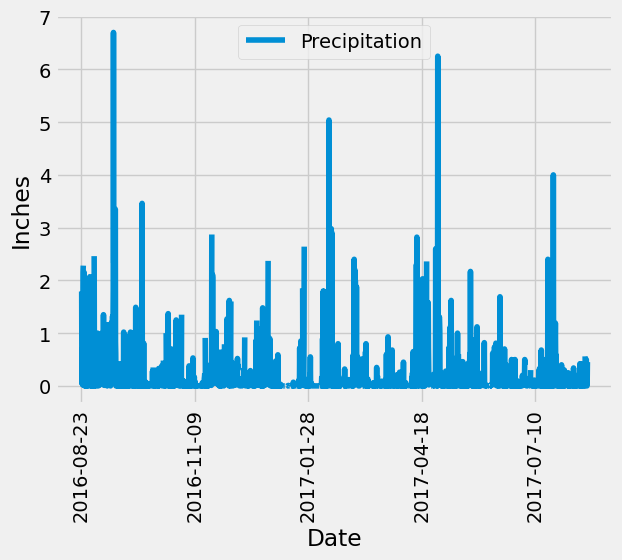

In [19]:
# Calculate the date one year from the last date in data set.
recent_date = pd.to_datetime(recent_date)
recent_date = recent_date.to_pydatetime()

# Perform a query to retrieve the data and precipitation scores
one_year_ago = recent_date - dt.timedelta(days=366)
prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(prcp, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values(by="Date")

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation', kind='line')
plt.xticks(rotation = 90)
plt.ylabel("Inches")

plt.show()

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
pd.DataFrame(summary_statistics)

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number of stations in the dataset
total_stations_query = session.query(Measurement.station).distinct().count()

total_stations_query

9

In [22]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Query to count the number of measurements per station, sorted in descending order
most_active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.station).label('count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Print the results
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

active_station = 'USC00519281'

temp_stats = session.query(func.min(Measurement.tobs).label('min_temp'),
                           func.max(Measurement.tobs).label('max_temp'),
                           func.avg(Measurement.tobs).label('avg_temp')
                          ).filter(Measurement.station == active_station).all()

min_temp, max_temp, avg_temp = temp_stats[0]
print(f"Lowest Temperature: {min_temp}")
print(f"Highest Temperature: {max_temp}")
print(f"Average Temperature: {avg_temp}")


Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


In [25]:
# Get the current date and calculate the date for 12 months ago
#one_year_ago = datetime.now() - timedelta(days=365)

# Query the previous 12 months of TOBS data for the most active station
tobs_data = session.query(Measurement.tobs).filter(
    Measurement.station == active_station,
    Measurement.date >= one_year_ago
).all()

# Convert the result into a list of temperature observations
temperatures = [temp[0] for temp in tobs_data]


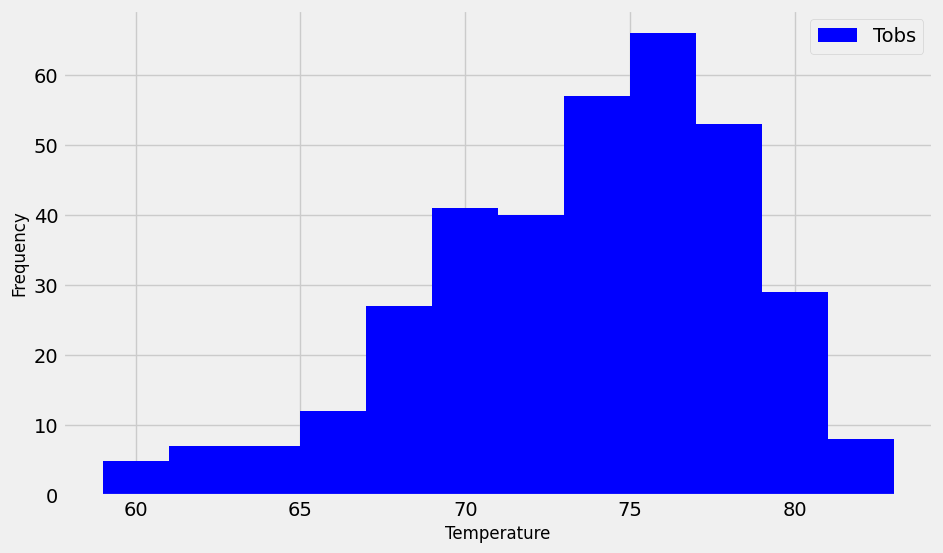

In [26]:
# Plotting the temperature data as a histogram with 12 bins
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, color='blue', label = "Tobs")

# Adding labels and title
plt.xlabel("Temperature", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(loc='upper right')

# Show the plot
plt.show()

# Close Session

In [27]:
# Close Session
session.close()